In [1]:
import numpy as np # linear algebra
import pandas as pd # data proclsessing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Any, Callable, Optional, Tuple
import cv2

C:\Users\LENOVO\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = A.Compose([
    ToTensorV2()
])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = np.array(self.loader(path))
        if self.transform is not None:
            sample = transform(image=sample)['image']
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

In [5]:
train_dir = 'D:\\College\\Projects\\Source Camera Identification\\256x256_aug\\train'
val_dir = 'D:\\College\\Projects\\Source Camera Identification\\256x256_aug\\val'
test_dir = 'D:\\College\\Projects\\Source Camera Identification\\256x256_aug\\test'

# train_dir = 'D:\\College\\Projects\\Source Camera Identification\\mini_dataset\\train'
# val_dir = 'D:\\College\\Projects\\Source Camera Identification\\mini_dataset\\val'
# test_dir = 'D:\\College\\Projects\\Source Camera Identification\\mini_dataset\\test'

train_data = CustomImageFolder(root = train_dir, transform = transform)
val_data = CustomImageFolder(root = val_dir, transform = transform)
test_data = CustomImageFolder(root = test_dir, transform = transform)

In [6]:
classes = train_data.classes
print("Classes:",classes)
num_classes = len(train_data.classes)
print("Number of Classes:",num_classes)

Classes: ['D01_Motorola_E3_1', 'D02_LG_OptimusL50_1', 'D03_Wiko_Lenny2_1', 'D04_LG_G3_1', 'D05_Apple_iPhone6s_1', 'D06_LG_G6_1', 'D07_Motorola_Z2Play_1', 'D08_Motorola_G8Plus_1', 'D09_Samsung_GalaxyS4mini_1', 'D10_Samsung_GalaxyJ1_1', 'D11_Samsung_GalaxyJ3_1', 'D12_Samsung_GalaxyStar5280_1', 'D13_Sony_XperiaE5_1', 'D14_Apple_iPhone3_1', 'D15_Samsung_GalaxyA6_1', 'D16_Samsung_GalaxyA6_2', 'D17_Apple_iPhone7_1', 'D18_Samsung_GalaxyS4_1', 'D19_Apple_iPhone8Plus_1', 'D20_Google_Pixel3_1', 'D21_Google_Nexus5_1', 'D22_BQ_AquarisX_1', 'D23_Huawei_P9lite_1', 'D24_Huawei_P8lite_1', 'D25_Huawei_P9lite_2', 'D26_Huawei_P20lite_1', 'D27_Google_PixelXL_1']
Number of Classes: 27


In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 128, shuffle = False)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11244\2963351193.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  plt.imshow(img.T)


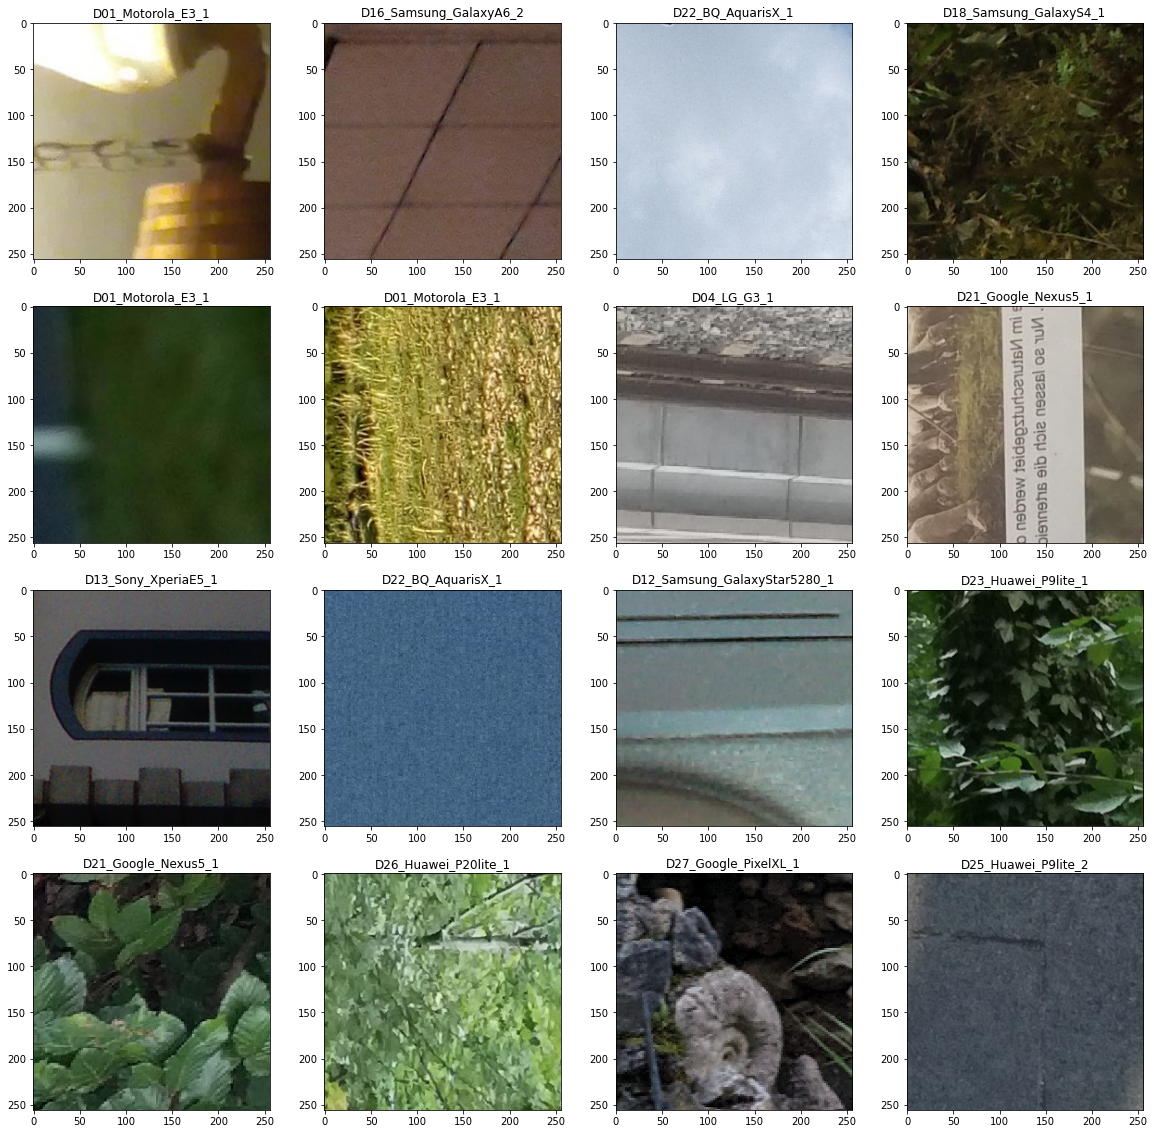

In [8]:
data, labels = next(iter(train_loader))
plt.figure(figsize=(20,20))
for idx, (img, x) in enumerate(zip(data, labels)):
    if idx > 15:
        break
    plt.subplot(4,4,idx+1)
    plt.title(classes[x])
    plt.imshow(img.T)

In [9]:
class SCINet(nn.Module):
    def __init__(self):
        super(SCINet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=7, padding=3)
        self.conv6 = nn.Conv2d(32, 128, kernel_size=3, padding=0)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.bottleneck_conv1 = nn.Conv2d(128, 32, kernel_size=3)
        
        self.max_pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
        
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        # RemNet block
        x_1 = self.conv3(x)
        x = x - x_1
                
        x = F.relu(self.conv4(x))
        
        x = self.max_pool(self.conv5(x))
        
        x = self.max_pool(F.relu(self.conv6(x)))
        
        # ResNet Block
        x_1 = self.conv7(x)
        x = x + x_1
        
        x = self.max_pool(self.conv7(x))
        x = self.max_pool(self.bottleneck_conv1(x))
        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
SCINet = SCINet().to(device)

In [10]:
print("Total parameters: ", sum(p.numel() for p in SCINet.parameters()))
print("Total trainable parameters: ", sum(p.numel() for p in SCINet.parameters() if p.requires_grad))

Total parameters:  407335
Total trainable parameters:  407335


In [11]:
crit = nn.CrossEntropyLoss()
optim = optim.Adam(SCINet.parameters())

In [26]:
if os.path.exists('SCINet_5_ep.pth'):
    chk = torch.load('SCINet_5_ep.pth')
    SCINet.load_state_dict(chk['model_state'])
    optim.load_state_dict(chk['optim_state'])
    print("Loaded checkpoint")
else:
    print("No checkpoint found !!")

Loaded checkpoint


In [27]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 5

In [28]:
def test_accuracy(model=SCINet, test_data=val_loader):
    with torch.no_grad():
        model.eval()
        testAcc = 0
        testloss = 0
        for i, (images, labels) in enumerate(test_data):
            images = images.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            trainloss = crit(outputs, labels)
            testloss += float(trainloss)

            # Checking accuracy
            preds = outputs.data.max(dim=1,keepdim=True)[1]
            testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
        testAcc = testAcc/len(test_loader.dataset) * 100
        testloss = testloss/len(test_loader)
        return testAcc, testloss

In [30]:
# Train the model
batches = len(train_loader)
for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    testloss = 0
    runningloss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            SCINet.train()
            images = images.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = SCINet(images)
            trainloss = crit(outputs, labels)
            runningloss += float(trainloss)

            # Backward and optimize
            optim.zero_grad()
            trainloss.backward()
            optim.step()

            # Checking accuracy
            preds = outputs.data.max(dim=1,keepdim=True)[1]
            trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
            images = images.to('cpu')
            labels = labels.to('cpu')

        trainAcc = trainAcc/len(train_loader.dataset) * 100

        testAcc, testloss = test_accuracy()

        print(f"Epoch {epoch+1} =>  Train Loss : {runningloss/batches};   Train Accuracy : {round(trainAcc.item(), 2)}%;   Test Accuracy : {round(testAcc.item(), 2)}%")

        TrainLoss.append(runningloss/batches)
        TrainAcc.append(trainAcc)

        TestLoss.append(testloss)
        TestAcc.append(testAcc)

        
        
        del images
        del labels
        del preds

100%|███████████████████████████████████████████████████████████████████████████| 3420/3420 [43:50<00:00,  1.30batch/s]


Epoch 1 =>  Train Loss : 2.183041152166344;   Train Accuracy : 30.37%;   Test Accuracy : 18.51%


100%|███████████████████████████████████████████████████████████████████████████| 3420/3420 [41:32<00:00,  1.37batch/s]


Epoch 2 =>  Train Loss : 2.0599445977406194;   Train Accuracy : 33.31%;   Test Accuracy : 36.45%


100%|███████████████████████████████████████████████████████████████████████████| 3420/3420 [41:41<00:00,  1.37batch/s]


Epoch 3 =>  Train Loss : 1.856875139684008;   Train Accuracy : 38.49%;   Test Accuracy : 36.44%


100%|███████████████████████████████████████████████████████████████████████████| 3420/3420 [46:44<00:00,  1.22batch/s]


Epoch 4 =>  Train Loss : 1.7966693546688348;   Train Accuracy : 40.14%;   Test Accuracy : 33.64%


100%|███████████████████████████████████████████████████████████████████████████| 3420/3420 [44:51<00:00,  1.27batch/s]


Epoch 5 =>  Train Loss : 1.7398523264461094;   Train Accuracy : 41.73%;   Test Accuracy : 41.32%


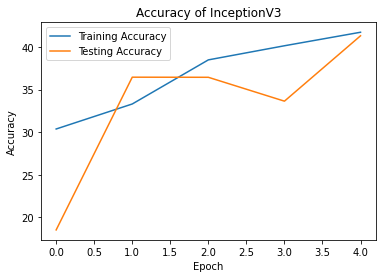

In [31]:
plt.plot(TrainAcc)
plt.plot(TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of InceptionV3")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

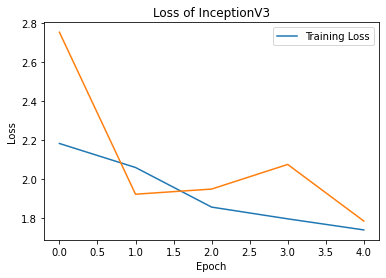

In [32]:
plt.plot(TrainLoss)
plt.plot(TestLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of InceptionV3")
plt.legend(["Training Loss"])
plt.show()

In [33]:
checkpoint = {
"epoch": 10,
"model_state": SCINet.state_dict(),
"optim_state": optim.state_dict()
}

In [34]:
torch.save(checkpoint, 'SCINet_10_ep.pth')